# Training a ML model using CICIoT2023

This notebook shows how a LogisticRegression model can be trained using the CICIoT2023 csv files.

In [3]:
#Regular EDA and plotting libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# We want our plots to appear in the notebook
%matplotlib inline

## Models
from tqdm import tqdm, trange
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import SMOTE
import joblib
import gc

In [4]:
DATASET_DIRECTORY = 'CICIoT2023/'

In [5]:
# List all files in the directory
df_sets = [f for f in os.listdir(DATASET_DIRECTORY) if os.path.isfile(os.path.join(DATASET_DIRECTORY, f)) and f.endswith('.csv')]
df_sets.sort()
# Check if there's at least one CSV file
if df_sets:
    # Construct the full path of the first CSV file
    first_csv_file_path = os.path.join(DATASET_DIRECTORY, df_sets[0])
    
    # Read the first CSV file into a DataFrame
    df = pd.read_csv(first_csv_file_path)
    print(f"Loaded {first_csv_file_path} into DataFrame.")
else:
    print("No CSV files found in the directory.")


Loaded CICIoT2023/part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv into DataFrame.


### Importing Dataset

In [6]:
# Splitting the data into training and test sets
training_sets, test_sets = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count',
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight',
]
y_column = 'label'

### Scaling

In [8]:
scaler = StandardScaler()

In [9]:
# Fit the scaler to the training data's features
scaler.fit(training_sets[X_columns])

# Transform the training and test data's features
training_sets_scaled = training_sets.copy()
test_sets_scaled = test_sets.copy()
training_sets_scaled[X_columns] = scaler.transform(training_sets[X_columns])
test_sets_scaled[X_columns] = scaler.transform(test_sets[X_columns])

In [12]:
# Check the number of samples for each class
class_counts = training_sets_scaled[y_column].value_counts()

In [13]:
# Find the minimum class count
min_class_count = class_counts.min()

In [14]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors=min_class_count-1)
X_train_resampled, y_train_resampled = smote.fit_resample(training_sets_scaled[X_columns], training_sets_scaled[y_column])

# Classification: 2 (1+1) Classes

In [15]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [16]:
# Define the models
ML_models = [
    LogisticRegression(n_jobs=-1),
    Perceptron(),
    AdaBoostClassifier(),
    RandomForestClassifier(n_jobs=-1),
    DecisionTreeClassifier()
]

# Define the model names
ML_names = [
    "LogisticRegression",
    "Perceptron",
    "AdaBoost",
    "RandomForest",
    "DecisionTree"
]

# Train each model on the resampled training data
for i, model in enumerate(ML_models):
    model.fit(X_train_resampled, y_train_resampled)
    print(f"{ML_names[i]} has been trained.")
    
    # Save the trained model
    filename = f"smote_model_2classes_{ML_names[i]}.sav"
    joblib.dump(model, filename)

# Evaluate models on test data
for name, model in zip(ML_names, ML_models):
    y_pred = model.predict(test_sets_scaled[X_columns])
    accuracy = accuracy_score(test_sets[y_column], y_pred)
    recall = recall_score(test_sets[y_column], y_pred, average='macro')
    precision = precision_score(test_sets[y_column], y_pred, average='macro')
    f1 = f1_score(test_sets[y_column], y_pred, average='macro')
    
    print(f"##### {name} #####")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\n")

/home/sc/0.DCU/00.Project/ML_based_IDS_for_IoT/project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression has been trained.
Perceptron has been trained.
AdaBoost has been trained.
RandomForest has been trained.
DecisionTree has been trained.
##### LogisticRegression #####
Accuracy: 0.7818
Recall: 0.5219
Precision: 0.4885
F1-Score: 0.4812


##### Perceptron #####
Accuracy: 0.7666
Recall: 0.5088
Precision: 0.4488
F1-Score: 0.4236


##### AdaBoost #####
Accuracy: 0.5715
Recall: 0.3677
Precision: 0.3983
F1-Score: 0.3218


##### RandomForest #####
Accuracy: 0.9904
Recall: 0.7173
Precision: 0.7375
F1-Score: 0.7225


##### DecisionTree #####
Accuracy: 0.9900
Recall: 0.8207
Precision: 0.7679
F1-Score: 0.7804




In [10]:
# Initialize the metrics_store_2classes dictionary
metrics_store_2classes = {}

# Loop through each trained model, predict on the test set, and evaluate
for model, name in tqdm(zip(trained_models, ML_names), desc="Evaluating models", total=len(ML_names)):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    metrics_store_2classes[name] = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }
    
    print(f"##### {name} (2 classes) #####")
    print('accuracy_score: ', accuracy)
    print('recall_score: ', recall)
    print('precision_score: ', precision)
    print('f1_score: ', f1)
    print("\n" * 3)
    
# Save the metrics to a file
joblib.dump(metrics_store_2classes, "models_evaluation_metrics.sav")
print("Metrics saved to file.")


Evaluating models:  20%|████████████████████████                                                                                                | 1/5 [00:01<00:04,  1.15s/it]

##### LogisticRegression (2 classes) #####
accuracy_score:  0.8025472370019691
recall_score:  0.4776626854836349
precision_score:  0.5733194123559405
f1_score:  0.4814479146407268






Evaluating models:  40%|████████████████████████████████████████████████                                                                        | 2/5 [00:02<00:03,  1.01s/it]

##### Perceptron (2 classes) #####
accuracy_score:  0.7735556579663999
recall_score:  0.4325090929795914
precision_score:  0.4565326457270362
f1_score:  0.40789040193456083






Evaluating models:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:04<00:03,  1.65s/it]

##### AdaBoost (2 classes) #####
accuracy_score:  0.5876241149608279
recall_score:  0.428646097362974
precision_score:  0.4918114867684781
f1_score:  0.41016830206239435






Evaluating models:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:06<00:01,  1.62s/it]

##### RandomForest (2 classes) #####
accuracy_score:  0.9915371402237212
recall_score:  0.7035924797972801
precision_score:  0.740916188891061
f1_score:  0.7112174563112037






Evaluating models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]

##### DecisionTree (2 classes) #####
accuracy_score:  0.9917675646235703
recall_score:  0.8764164762047777
precision_score:  0.8310793660852848
f1_score:  0.8431035901042757




Metrics saved to file.


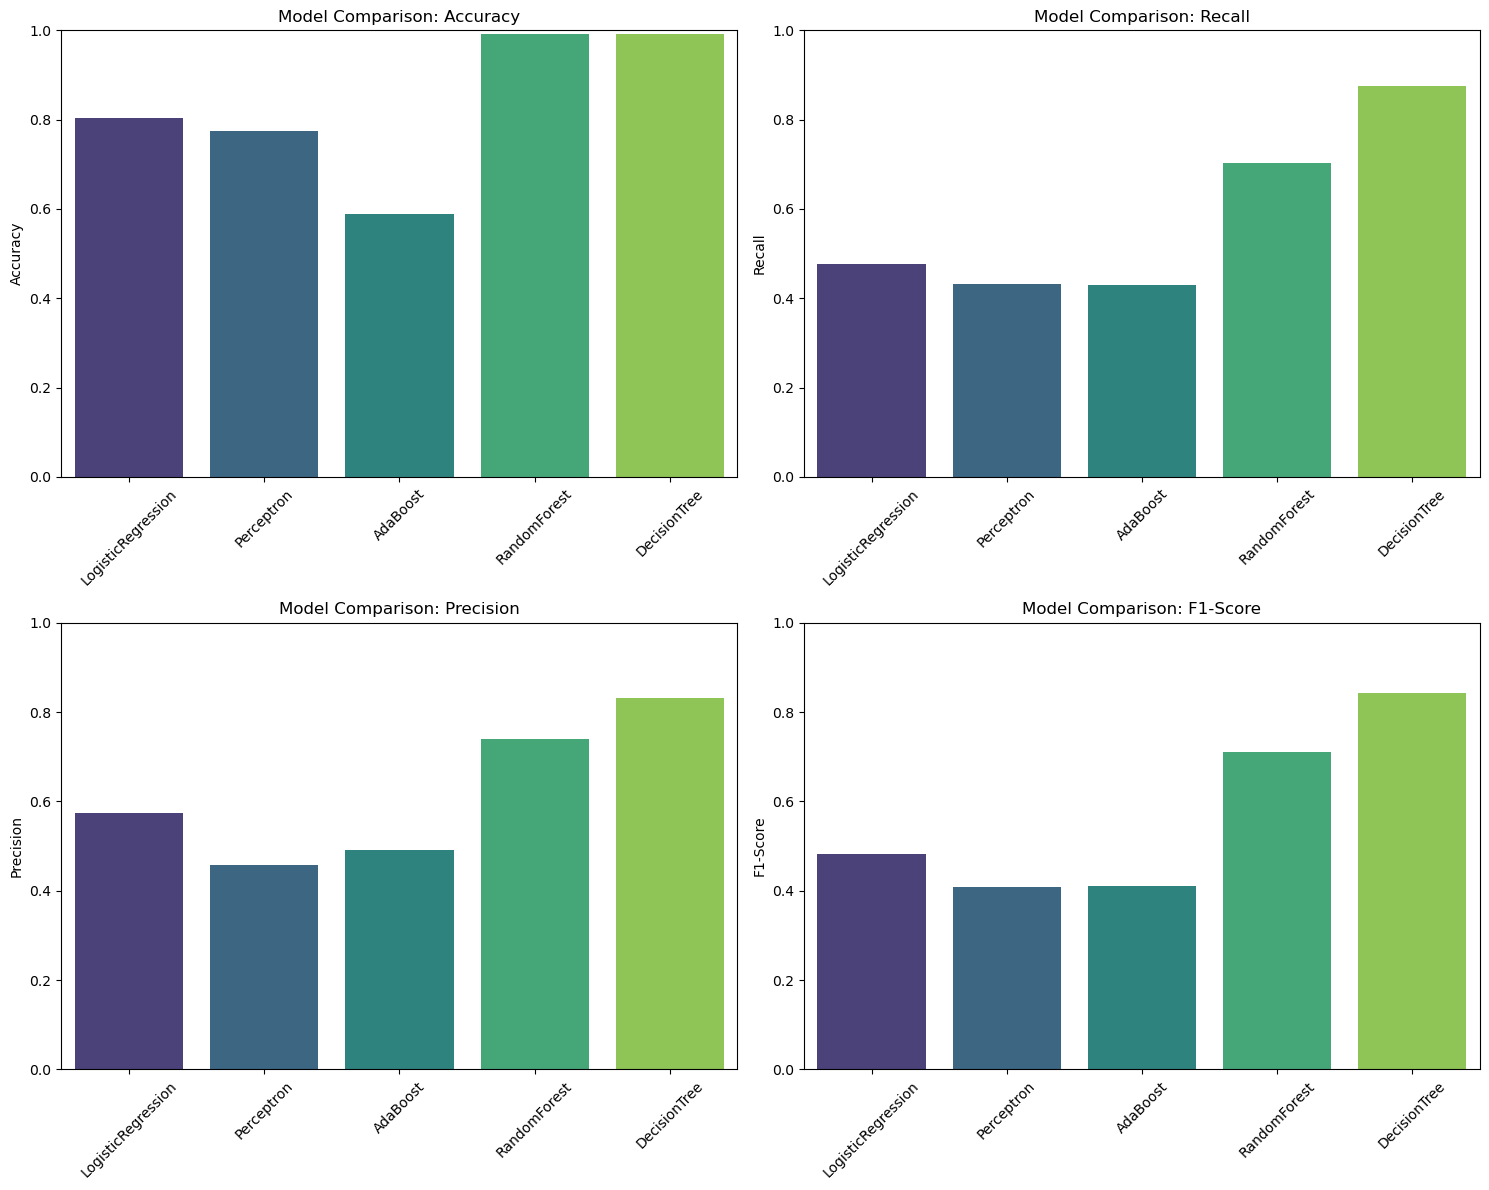

In [17]:
# Load the saved metrics from the joblib file
metrics_store_2classes = joblib.load("models_evaluation_metrics.sav")

# Extract metrics from the loaded data
accuracies = [metrics_store_2classes[model]['accuracy'] for model in ML_names]
recalls = [metrics_store_2classes[model]['recall'] for model in ML_names]
precisions = [metrics_store_2classes[model]['precision'] for model in ML_names]
f1_scores = [metrics_store_2classes[model]['f1'] for model in ML_names]

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Define metrics and their names for plotting
metrics = [accuracies, recalls, precisions, f1_scores]
metric_names = ['Accuracy', 'Recall', 'Precision', 'F1-Score']

# Plot each metric
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=ML_names, y=metric, palette="viridis")
    plt.title(f'Model Comparison: {metric_name}')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Since all metrics are in the range [0, 1]

plt.tight_layout()
plt.show()
